In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
from tabulate import tabulate

In [2]:
# Steps

N = 120
G = 32
P = 42
D = 0.2

P2 = 2 * P + 1

T_STEP = int(P / 5) + 1
I_STEP = int(N / 10) + 1

%run -i ./PHT-RIW-Library.ipynb

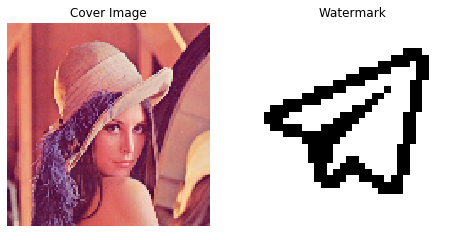

In [3]:
# Import images
ori_img = cv2.imread('./assets/lena.png') #BGR
ori_logo = cv2.imread('./assets/paperplane.png', 0)

n = N
p = P
g = G
d = D

# Preprocess Image
IMG_BGR = cv2.resize(ori_img, (n, n)) # Original Image
IMG_Y = getYFromBGR(IMG_BGR) #

# Preprocess Logo
LOGO = cv2.resize(ori_logo, (g,g))
LOGO = (LOGO >= 128) * 1
# LOGO = LOGO * 0

imgshow([[IMG_BGR, LOGO]], [['Cover Image', 'Watermark']])

Generating Compensation Image

Progress: [####################] 100.0%


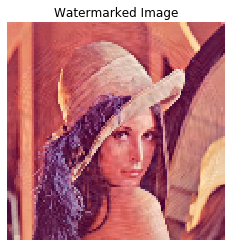

In [28]:
imgWatermarked = watermarkEmbedToImage(IMG_BGR, LOGO, n, g, p, d)
imgshow1(imgWatermarked, 'Watermarked Image')

In [29]:
# Calculate PSNR
MSE = np.mean((imgWatermarked - IMG_BGR) ** 2)
PSNR = 10 * np.log10(255 * 255 / MSE)

print(tabulate([[n, g, p, d, PSNR]], headers=['N', 'G', 'P', 'D', 'PSNR'], tablefmt='orgtbl'))

|   N |   G |   P |   D |    PSNR |
|-----+-----+-----+-----+---------|
| 120 |  32 |  42 | 0.2 | 33.0945 |


In [30]:
def war(image, n):
    attackedImages = []
    
    # No Attack
    attackedImages.append((np.copy(image), 'No Attack'))
    
    # Attack: Rotation
    ROTATION_ANGLE = 30
    imgRotate = attackRotation(image, ROTATION_ANGLE)
    attackedImages.append((imgRotate, 'Rotation {}° CW'.format(ROTATION_ANGLE)))
    
    # Attack: Scaling
    RESIZE_FACTOR = 0.85
    imgResize = attackResize(image, int(RESIZE_FACTOR * n))
    attackedImages.append((imgResize, 'Scaling ' + '{:.0%}'.format(RESIZE_FACTOR)))
    
    # Attack: Translation
    TR_X = 10
    TR_Y = -10
    imgTranslate = attackTranslateByPixel(image, TR_X, TR_Y)
    attackedImages.append((imgTranslate, 'Translation By Pixel X={} Y={}'.format(TR_X, TR_Y)))
    
    # Attack: Crop
    CROP_PERCENTAGE = 0.03
    imgCrop = attackCrop(image, CROP_PERCENTAGE, CROP_PERCENTAGE, CROP_PERCENTAGE, CROP_PERCENTAGE)
    attackedImages.append((imgCrop, 'Crop {:.0%}'.format(CROP_PERCENTAGE)))
    
    # Attack: BLUR
    BLUR_KERNEL_SIZE = 3
    imgBlur = attackFilterAverage(image, BLUR_KERNEL_SIZE)
    attackedImages.append((imgBlur, 'Blur K={}'.format(BLUR_KERNEL_SIZE)))

    # Attack: Black & Pepper Noise
    NOISE_PERCENTAGE = 0.03
    imgNoise = attackNoiseSaltPepper(image, NOISE_PERCENTAGE)
    attackedImages.append((imgNoise, 'Noise {:.0%}'.format(NOISE_PERCENTAGE)))

    # Attack: JPG Compression
    COMPRESSION_QUALITY = 85
    imgJpg = attackJPG(image, COMPRESSION_QUALITY)
    attackedImages.append((imgJpg, 'JPG Compression Q={}'.format(COMPRESSION_QUALITY)))
    
    return attackedImages

In [31]:
extractedLogos = [None]*20
extractedBers = [None]*20
attackedImages = [None]*20
attackTitles = [None]*20

In [32]:
imgAttackedList = war(imgWatermarked, n)

In [36]:
%run -i ./PHT-RIW-Library.ipynb

BER = 0.20%
(0, 0, 1, dtype('uint8'))


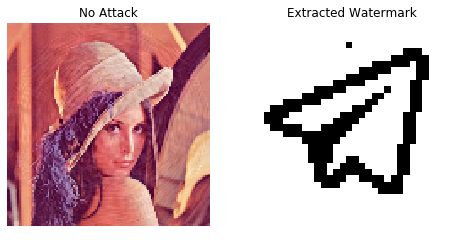

In [37]:
index = 0
(attackedImages[index], attackTitles[index]) = imgAttackedList[index]
(extractedLogos[index], extractedBers[index], transformation) = watermarkExtractFromImage(attackedImages[index], imgWatermarked, LOGO, n, g, p, d, False, 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, attackTitles[index]))

clear_output(wait = True)
print('BER = {:.2%}'.format(extractedBers[index]))
print(transformation)
imgshow([[attackedImages[index], extractedLogos[index]]], [[attackTitles[index], 'Extracted Watermark']])

Generating Compensation Image

Progress: [####################] 100.0%


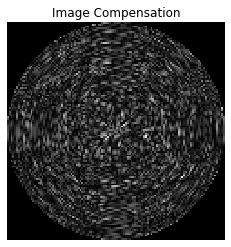

In [123]:
imgY = getYFromBGR(IMG_BGR) #
momen = transformPHT(imgY, n, p, 'Calculating Momen\n{}'.format(''))

(logoPositioned, logoFilter, maxCapacity) = watermarkEmbed(LOGO, p)

momenExpected = 2 * d * np.round(np.abs(momen) / 2 / d)
momenExpected = momenExpected + d / 2 * (logoPositioned == 1)
momenExpected = momenExpected - d / 2 * (logoPositioned == 0)
momenExpected = momenExpected + 2 * d * (momenExpected < 0)

momenDiff = momenExpected - np.abs(momen)
momenDiff = momenDiff / (np.abs(momen) + 0.000000001) * momen

omega = momenDiff * logoFilter

imgCompensation = inversePHT(omega, n, p, 'Generating Compensation Image\n{}'.format(''))

imgshow1(imgCompensation, 'Image Compensation')

1.0 32.50040244324669 (-30.812320520655604-1.5439038936193583e-16j) (26.823898399845547-1.3773704399255848e-15j)
0.8 32.55437266366917 (-24.649856416524486-1.2351231148954867e-16j) (21.45911871987644-1.101896351940468e-15j)
0.6 32.95754570360082 (-18.48739231239336-9.26342336171615e-17j) (16.09433903990733-8.264222639553509e-16j)
0.4 34.88456693766179 (-12.324928208262243-6.175615574477434e-17j) (10.72955935993822-5.50948175970234e-16j)
0.2 41.31299081196249 (-6.1624641041311214-3.087807787238717e-17j) (5.36477967996911-2.75474087985117e-16j)


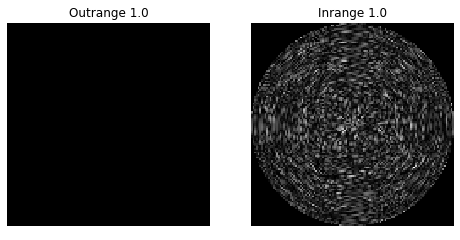

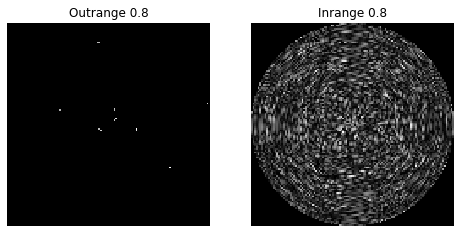

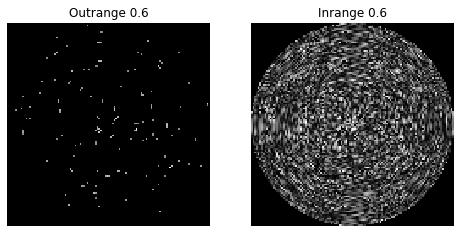

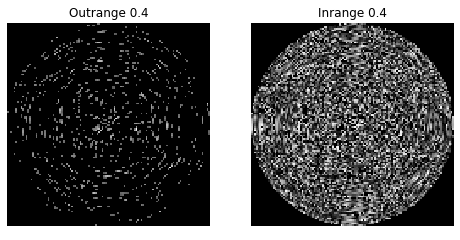

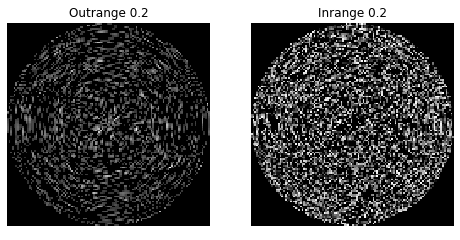

In [107]:
# G = 32

for i in range(10, 0, -2):
    minVal = i / 10 * np.min(imgCompensation)
    maxVal = i / 10 * np.max(imgCompensation)
    outside = imgCompensation * np.logical_or(imgCompensation < minVal, imgCompensation > maxVal)
    inside = imgCompensation * np.logical_and(imgCompensation > minVal, imgCompensation < maxVal)
    imgshow([[outside, inside]], [['Outrange {}'.format(i/10), 'Inrange {}'.format(i/10)]])
    mseclip = np.mean(np.abs(inside) ** 2)
    psnrclip = 10 * np.log10(255 * 255 / mseclip)
    print(i/10, psnrclip, minVal, maxVal)

1.0 40.79652094327812 (-9.68491381080543+6.938893903907228e-18j) (10.617265879770715-6.661338147750939e-16j)
0.8 40.91895083572459 (-7.747931048644344+5.551115123125783e-18j) (8.493812703816571-5.329070518200752e-16j)
0.6 41.41722934354637 (-5.810948286483257+4.163336342344337e-18j) (6.370359527862429-3.996802888650563e-16j)
0.4 43.63660222095959 (-3.873965524322172+2.7755575615628915e-18j) (4.246906351908286-2.664535259100376e-16j)
0.2 50.741234551423574 (-1.936982762161086+1.3877787807814458e-18j) (2.123453175954143-1.332267629550188e-16j)


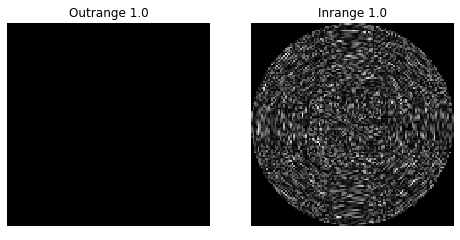

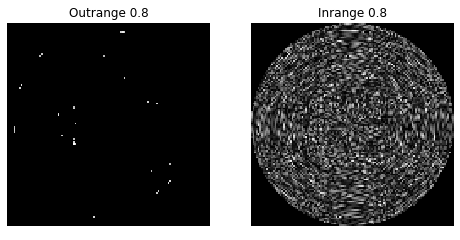

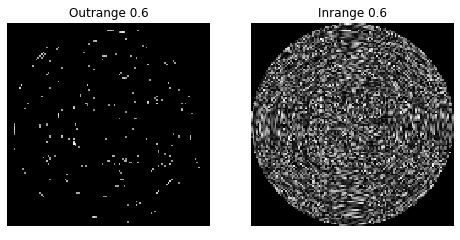

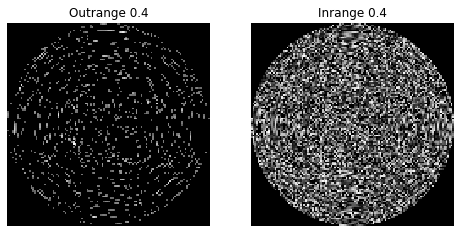

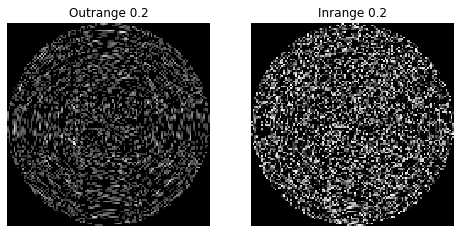

In [101]:
# G = 12

for i in range(10, 0, -2):
    minVal = i / 10 * np.min(imgCompensation)
    maxVal = i / 10 * np.max(imgCompensation)
    outside = imgCompensation * np.logical_or(imgCompensation < minVal, imgCompensation > maxVal)
    inside = imgCompensation * np.logical_and(imgCompensation > minVal, imgCompensation < maxVal)
    imgshow([[outside, inside]], [['Outrange {}'.format(i/10), 'Inrange {}'.format(i/10)]])
    mseclip = np.mean(np.abs(inside) ** 2)
    psnrclip = 10 * np.log10(255 * 255 / mseclip)
    print(i/10, psnrclip, minVal, maxVal)

(-12.324928208262243-6.175615574477434e-17j) (10.72955935993822-5.50948175970234e-16j)
|   N |   G |   P |   D |    PSNR |
|-----+-----+-----+-----+---------|
| 120 |  32 |  42 | 0.2 | 33.2639 |


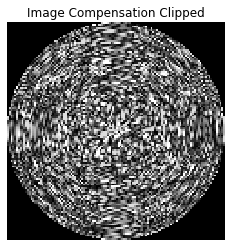

In [124]:
fff = 0.4
(mn, mx) = (fff * np.min(imgCompensation), fff * np.max(imgCompensation))
imgCompensationClipped = np.clip(imgCompensation,  mn, mx)
imgshow1(imgCompensationClipped, 'Image Compensation Clipped')
print(np.min(imgCompensationClipped), np.max(imgCompensationClipped))

# Calculate PSNR
mseclip = np.mean(np.abs(imgCompensationClipped) ** 2)
psnrclip = 10 * np.log10(255 * 255 / mseclip)

print(tabulate([[n, g, p, d, psnrclip]], headers=['N', 'G', 'P', 'D', 'PSNR'], tablefmt='orgtbl'))

|   N |   G |   P |   D |    PSNR |
|-----+-----+-----+-----+---------|
| 120 |  32 |  42 | 0.2 | 33.1931 |


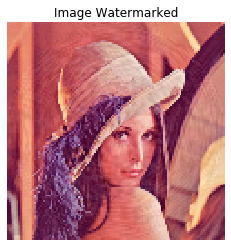

In [125]:
# imgYWatermarked = imgY + imgCompensation
imgYWatermarked = imgY + imgCompensationClipped
imgWatermarked = putYToBGR(imgYWatermarked, IMG_BGR)

# Calculate PSNR
MSE = np.mean((imgWatermarked - IMG_BGR) ** 2)
PSNR = 10 * np.log10(255 * 255 / MSE)

print(tabulate([[n, g, p, d, PSNR]], headers=['N', 'G', 'P', 'D', 'PSNR'], tablefmt='orgtbl'))

imgshow1(imgWatermarked, 'Image Watermarked')

BER = 0.10%
(0, 0, 1)


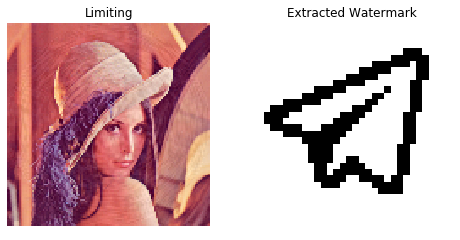

In [119]:
(extractedLogoTest, extractedBerTest, transformation) = watermarkExtractFromImage(imgWatermarked, imgWatermarked, LOGO, n, g, p, d, False, 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, 'Limiting'))

clear_output(wait = True)
print('BER = {:.2%}'.format(extractedBerTest))
print(transformation)
imgshow([[imgWatermarked, extractedLogoTest]], [['Limiting', 'Extracted Watermark']])

In [ ]:
index = 1
(attackedImages[index], attackTitles[index]) = imgAttackedList[index]
(extractedLogos[index], extractedBers[index], transformation) = watermarkExtractFromImage(attackedImages[index], imgWatermarked, LOGO, n, g, p, d, False, 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, attackTitles[index]))

clear_output(wait = True)
print('BER = {:.2%}'.format(extractedBers[index]))
print(transformation)
imgshow([[attackedImages[index], extractedLogos[index]]], [[attackTitles[index], 'Extracted Watermark']])

In [ ]:
index = 2
(attackedImages[index], attackTitles[index]) = imgAttackedList[index]
(extractedLogos[index], extractedBers[index], transformation) = watermarkExtractFromImage(attackedImages[index], imgWatermarked, LOGO, n, g, p, d, False, 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, attackTitles[index]))

clear_output(wait = True)
print('BER = {:.2%}'.format(extractedBers[index]))
print(transformation)
imgshow([[attackedImages[index], extractedLogos[index]]], [[attackTitles[index], 'Extracted Watermark']])

In [ ]:
index = 3
(attackedImages[index], attackTitles[index]) = imgAttackedList[index]
(extractedLogos[index], extractedBers[index], transformation) = watermarkExtractFromImage(attackedImages[index], imgWatermarked, LOGO, n, g, p, d, True, 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, attackTitles[index]))

clear_output(wait = True)
print('BER = {:.2%}'.format(extractedBers[index]))
print(transformation)
imgshow([[attackedImages[index], extractedLogos[index]]], [[attackTitles[index], 'Extracted Watermark']])

In [ ]:
index = 4
(attackedImages[index], attackTitles[index]) = imgAttackedList[index]
(extractedLogos[index], extractedBers[index], transformation) = watermarkExtractFromImage(attackedImages[index], imgWatermarked, LOGO, n, g, p, d, False, 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, attackTitles[index]))

clear_output(wait = True)
print('BER = {:.2%}'.format(extractedBers[index]))
print(transformation)
imgshow([[attackedImages[index], extractedLogos[index]]], [[attackTitles[index], 'Extracted Watermark']])

In [ ]:
index = 5
(attackedImages[index], attackTitles[index]) = imgAttackedList[index]
(extractedLogos[index], extractedBers[index], transformation) = watermarkExtractFromImage(attackedImages[index], imgWatermarked, LOGO, n, g, p, d, False, 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, attackTitles[index]))

clear_output(wait = True)
print('BER = {:.2%}'.format(extractedBers[index]))
print(transformation)
imgshow([[attackedImages[index], extractedLogos[index]]], [[attackTitles[index], 'Extracted Watermark']])

In [ ]:
index = 6
(attackedImages[index], attackTitles[index]) = imgAttackedList[index]
(extractedLogos[index], extractedBers[index], transformation) = watermarkExtractFromImage(attackedImages[index], imgWatermarked, LOGO, n, g, p, d, False, 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, attackTitles[index]))

clear_output(wait = True)
print('BER = {:.2%}'.format(extractedBers[index]))
print(transformation)
imgshow([[attackedImages[index], extractedLogos[index]]], [[attackTitles[index], 'Extracted Watermark']])

In [ ]:
index = 7
(attackedImages[index], attackTitles[index]) = imgAttackedList[index]
(extractedLogos[index], extractedBers[index], transformation) = watermarkExtractFromImage(attackedImages[index], imgWatermarked, LOGO, n, g, p, d, False, 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, attackTitles[index]))

clear_output(wait = True)
print('BER = {:.2%}'.format(extractedBers[index]))
print(transformation)
imgshow([[attackedImages[index], extractedLogos[index]]], [[attackTitles[index], 'Extracted Watermark']])

In [ ]:
print(tabulate(
    [
        attackTitles[0:8],
        list(map(lambda x: '{:.0%}'.format(x), extractedBers[0:8]))
    ],
    tablefmt='orgtbl'
))

In [ ]:
# Multiple Attacks

In [ ]:
multipleAttacked = np.copy(imgWatermarked)
multipleAttacked = attackRotation(multipleAttacked, 10)
multipleAttacked = attackResize(multipleAttacked, 300)
multipleAttacked = attackRandomNoise(multipleAttacked, 0.03)
multipleAttacked = attackBlur(multipleAttacked, 3)
multipleAttacked = attackCrop(multipleAttacked, 0.03, 0.03, 0.03, 0.03)
multipleAttacked = attackJPG(multipleAttacked, 90)

imgshow1(multipleAttacked, 'MultipleAttack')

In [ ]:
(miLogo, miBer, miTrf) = watermarkExtractFromImage(multipleAttacked, IMG_WATERMARKED, LOGO, n, g, p, d, False, 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, 'MultipleAttack'))

clear_output(wait = True)
print('BER = {:.2%}'.format(miBer))
print(miTrf)
imgshow([[multipleAttacked, miLogo]], [['MultipleAttack', 'Extracted Watermark']])